In [1]:
import numpy as np
from graphviz import Digraph


In [2]:
def _trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_graph(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = _trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            # name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record'
            name=uid,
            # label="{ %s | data %s | grad %s }" % (n.label, n.data, n.grad),
            label="{ data %s | grad %s }" % (n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



In [3]:
class Scaler:
    def __init__(self, data, _prev=(), _op=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_prev)
        self._op = _op

    def _convert(self, other):
        if isinstance(other, Scaler):
            return other
        elif isinstance(other, (int, float)):
            return Scaler(other)
        else:
            raise Exception("Unsupported datatype!")

    def __add__(self, other):
        other = self._convert(other)
        res = Scaler(self.data + other.data, (self, other), "+")

        def backward():
            self.grad += res.grad
            other.grad += res.grad

        res._backward = backward

        return res

    def __mul__(self, other):
        other = self._convert(other)
        res = Scaler(self.data * other.data, (self, other), "*")

        def backward():
            self.grad += other.data * res.grad
            other.grad += self.data * res.grad

        res._backward = backward

        return res

    def __pow__(self, other):
        if isinstance(other, (int, float)):
            res = Scaler(self.data**other, (self,), f"**{other}")

            def backward():
                self.grad += other * (self.data ** (other - 1)) * res.grad

            res._backward = backward
            return res
        elif isinstance(other, Scaler):
            res = Scaler(self.data**other.data, (self, other), f"^{other.data}")

            def backward():
                self.grad += other.data * (self.data ** (other.data - 1)) * res.grad
                other.grad += self.data**other.data * np.log(self.data)

            res._backward = backward
            return res
        else:
            raise Exception("Only int, float & Scaler are alllowed for power op.")

    # TODO: seperate the activation function from here
    def relu(self):
        res = Scaler(0 if self.data < 0 else self.data, (self,), "ReLU")

        def backward():
            self.grad += (res.data > 0) * res.grad

        res._backward = backward

        return res

    def tanh(self):
        x = self.data
        t = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        res = Scaler(t, (self,), "TanH")

        def backward():
            self.grad += (1 - t**2) * res.grad

        res._backward = backward
        return res

    def backward(self):
        # build the topological graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for prev in v._prev:
                    build_topo(prev)
                topo.append(v)

        build_topo(self)

        # set the gradient of the current node to 1
        self.grad = 1.0

        # run the _backward for all nodes
        for node in reversed(topo):
            node._backward()

    def __truediv__(self, other):  # self / other
        return self * (other**-1)

    def __rtruediv__(self, other):  # other / self
        return self._convert(other) * self**-1

    def __rmul__(self, other):  # other * self
        return self * self._convert(other)

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return self + (-self._convert(other))

    def __radd__(self, other):  # other + self
        return self + self._convert(other)

    def __repr__(self):
        return f"Scaler({self.data})"


In [74]:
class Tensor(np.ndarray):
    def __init__(self, *args, **kwargs):
        super(np.ndarray, self).__init__()

    def __new__(cls, tensor):
        return np.vectorize(lambda x: Scaler(x))(np.asarray(tensor)).view(cls)

    def backward(self):
        # np.vectorize(lambda x: x.backward())(self) # this line of statement doesn't seems to work :( don't know why?
        for s in self.flatten():
            s.backward()

    @property
    def grad(self):
        return np.vectorize(lambda x: x.grad)(self)

    @grad.setter
    def grad(self, new_grad: int | float):
        for s in self.flatten():
            s.grad = new_grad

    @property
    def data(self):
        return np.vectorize(lambda x: x.data)(self)

    @data.setter
    def data(self, new_data):
        new_data = new_data.flatten()
        for i, s in enumerate(self.flatten()):
            s.data = new_data[i]

    def relu(self):
        return np.vectorize(lambda x: x.relu())(self)

    def tanh(self):
        return np.vectorize(lambda x: x.tanh())(self)


In [78]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])  # (4, 2)
Y = np.array([[0], [1], [1], [0]])              # (4, 1)

n_in = 2
n_out = 1

W1 = Tensor(np.random.uniform(-1, 1, (n_in, 3))) # n_in, out
b1 = Tensor(np.random.uniform(-1, 1, (1, 3)))    # 1, out

W2 = Tensor(np.random.uniform(-1, 1, (3, n_out)))
b2 = Tensor(np.random.uniform(-1, 1, (1, n_out)))

yHat1 = X @ W1 + b1
yHat2 = yHat1 @ W2 + b2
yHat2.shape


(4, 1)

In [79]:
lr = .05

for i in range(200):
    
    # forward prop
    yHat1 = X @ W1 + b1
    yHat1 = yHat1.tanh()
    yHat2 = yHat1 @ W2 + b2
    
    # calc loss
    loss = sum((yHat2 - Y) ** 2)

    # zero_grad
    W1.grad = 0
    b1.grad = 0
    W2.grad = 0
    b2.grad = 0

    # backward prop
    loss.backward()

    # optimizer step
    W1.data = W1.data - lr * W1.grad
    b1.data = b1.data - lr * b1.grad

    W2.data = W2.data - lr * W2.grad
    b2.data = b2.data - lr * b2.grad

    # print loss
    if i % 20 == 0:
        print(loss)


[Scaler(2.691555800220264)]
[Scaler(0.9680705131296848)]
[Scaler(0.9452280553487946)]
[Scaler(0.9231262826191573)]
[Scaler(0.8941848729535058)]
[Scaler(0.854094942448348)]
[Scaler(0.7957746632022545)]
[Scaler(0.7021638539869546)]
[Scaler(0.5476605356253981)]
[Scaler(0.33367340633058434)]


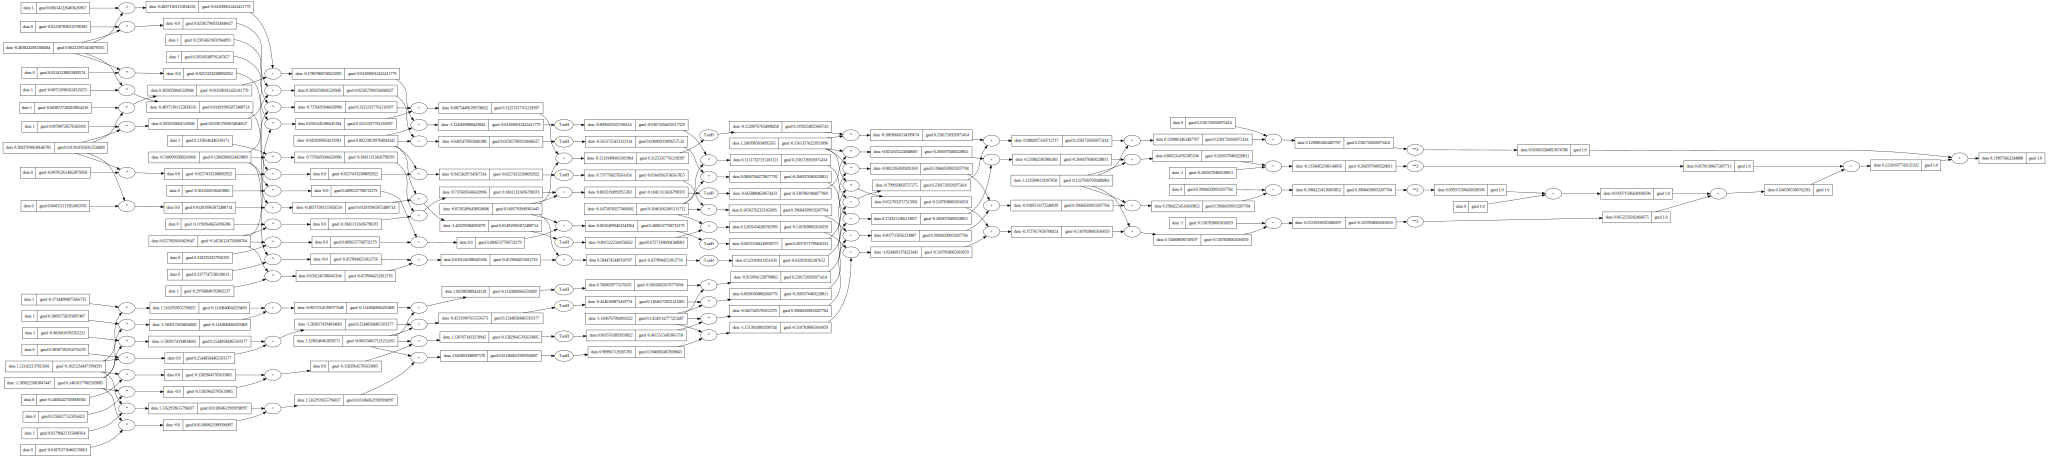

In [80]:
draw_graph(loss[0])

In [81]:
yHat1 = X @ W1 + b1
yHat1 = yHat1.tanh()
yHat2 = yHat1 @ W2 + b2

yHat2

Tensor([[Scaler(0.19247719801688334)],
        [Scaler(0.7521658083587182)],
        [Scaler(0.8697906107227767)],
        [Scaler(0.1250815173111779)]], dtype=object)

In [82]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters():
        return []


class Linear(Module):
    def __init__(self, in_features, out_features, bias=True):
        self.bias = bias
        self.W = Tensor(np.random.uniform(-1, 1, (in_features, out_features)))
        if self.bias:
            self.b = Tensor(np.random.uniform(-1, 1, (1, out_features)))

    def __call__(self, X: Tensor):
        out = X @ self.W + self.b
        return out

    def parameters(self):
        return [self.W, self.b] if self.bias else [self.W]


In [97]:
X = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])  # (4, 2)
Y = Tensor([[0], [1], [1], [0]])  # (4, 1)


class Model(Module):
    def __init__(self, n_in, n_out):
        self.l1 = Linear(n_in, 3)
        self.l2 = Linear(3, n_out)

    def __call__(self, x):
        x = self.l1(x).tanh()
        x = self.l2(x)
        return x

    def parameters(self):
        return self.l1.parameters() + self.l2.parameters()


model = Model(2, 1)
model(X).shape


(4, 1)

In [98]:
lr = 0.05
n_epochs = 200

for epoch_i in range(n_epochs):
    # forward prop
    yHat = model(X)

    loss = np.sum((yHat - Y) ** 2)

    model.zero_grad()
    loss.backward()

    # optimizer.step()
    for p in model.parameters():
        # pre = p.data
        p.data = p.data - lr * p.grad
        # print(np.sum(p.data - pre))

    if epoch_i % 20 == 0:
        print(loss)


Scaler(1.3625158739779715)
Scaler(0.8783567633165138)
Scaler(0.7860481337561271)
Scaler(0.6448744744832782)
Scaler(0.4518156378020953)
Scaler(0.23971734670521522)
Scaler(0.08681401113541895)
Scaler(0.02227137732962837)
Scaler(0.004600880594017831)
Scaler(0.000852554229164511)


In [99]:
model(X)


Tensor([[Scaler(0.0026204505411613344)],
        [Scaler(0.9938286603605753)],
        [Scaler(0.9942318198542188)],
        [Scaler(0.008498736688216879)]], dtype=object)